In [80]:
# import libraries
import numpy as np
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

%load_ext autoreload
%autoreload 2

# load in directories
from experiment_code.constants import Defaults
#from experiment_code.preprocess import CoRTScaling
from experiment_code.visualization.visualize import CoRTLanguageExp


!pip install urllib3
import urllib.request, json
import requests

#pip install py_linq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Non-CoRT Stimuli

In [81]:
# get low and high cloze prob
def clean_df(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
    #dataframe.rows = dataframe.rows.str.replace(' ', '')
    dataframe.columns = dataframe.columns.str.replace('?', '')
    
    dataframe = dataframe.query('NORMED==" YES"')
    
    df_min = dataframe.groupby(['CUE'])['FSG'].apply(lambda x: x.min()).reset_index()
    df_min = df_min.merge(df, on=['CUE', 'FSG']).add_prefix('MIN_')
    df_min = df_min.groupby('MIN_CUE').last().reset_index()

    df_max = dataframe.groupby(['CUE'])['FSG'].apply(lambda x: x.max()).reset_index()
    df_max = df_max.merge(df, on=['CUE', 'FSG']).add_prefix('MAX_')
    df_max = df_max.groupby('MAX_CUE').last().reset_index()

    df_concat = pd.concat([df_min, df_max], axis=1).reset_index(drop=True)
    
    return df_concat

In [82]:
# read in word databses
os.chdir(Defaults.STIM_DIR)
file_list = glob.glob('cue_target_pairs*')

df_all = pd.DataFrame()
for file in file_list:
    df = pd.read_csv(file)
    
    df_grouped = clean_df(dataframe=df)
    df_all = pd.concat([df_all, df_grouped])

In [83]:
df_all['MAX_CUE'].astype(str).str[0].unique()

array(['A', 'B', 'T', 'D', 'L', 'M', 'S', 'C', 'P', 'G', 'H'],
      dtype=object)

In [84]:
df_exp_noncort = df_all.filter({'MAX_CUE','MAX_TARGET','MAX_FSG','MAX_#P','MAX_#G','MIN_CUE','MIN_TARGET','MIN_FSG','MIN_#P','MIN_#G'})
#only going up to 'H'?
#~500 for A-B df -> should be ~4000
df_exp_noncort

,MAX_TARGET,MIN_#G,MAX_#G,MAX_#P,MIN_CUE,MAX_CUE,MAX_FSG,MIN_FSG,MIN_#P,MIN_TARGET
0,THE,152.0,152.0,10.0,A,A,0.066,0.013,2.0,WORD
1,ANIMAL,152.0,152.0,49.0,AARDVARK,AARDVARK,0.322,0.013,2.0,ZOO
2,STOMACH,152.0,152.0,86.0,ABDOMEN,ABDOMEN,0.566,0.013,2.0,SIX PACK
3,KIDNAP,150.0,150.0,68.0,ABDUCT,ABDUCT,0.453,0.013,2.0,OPEN
4,CAPABILITY,143.0,143.0,17.0,ABILITY,ABILITY,0.119,0.014,2.0,WORK
5,WILLING,148.0,148.0,39.0,ABLE,ABLE,0.264,0.014,2.0,WELL
6,NORMAL,139.0,139.0,39.0,ABNORMAL,ABNORMAL,0.281,0.014,2.0,UNUSUAL
7,BELOW,140.0,140.0,79.0,ABOVE,ABOVE,0.564,0.014,2.0,SKY
8,GOOD,152.0,152.0,22.0,ABSENCE,ABSENCE,0.145,0.013,2.0,WITHOUT
9,PRESENT,143.0,143.0,42.0,ABSENT,ABSENT,0.294,0.014,2.0,THERE


In [85]:
#uncapitalize
df_exp_noncort = df_exp_noncort.applymap(lambda s:s.lower() if type(s) == str else s)

In [86]:
#df_exp_noncort['random_word'] = 
df_exp_noncort['random_word'] = df_exp_noncort['MIN_TARGET'].sample(n=len(df_exp_noncort), replace=False, random_state=2).to_list()

In [87]:
df_exp_noncort

,MAX_TARGET,MIN_#G,MAX_#G,MAX_#P,MIN_CUE,MAX_CUE,MAX_FSG,MIN_FSG,MIN_#P,MIN_TARGET,random_word
0,the,152.0,152.0,10.0,a,a,0.066,0.013,2.0,word,traveler
1,animal,152.0,152.0,49.0,aardvark,aardvark,0.322,0.013,2.0,zoo,catholic
2,stomach,152.0,152.0,86.0,abdomen,abdomen,0.566,0.013,2.0,six pack,light
3,kidnap,150.0,150.0,68.0,abduct,abduct,0.453,0.013,2.0,open,personal
4,capability,143.0,143.0,17.0,ability,ability,0.119,0.014,2.0,work,job
5,willing,148.0,148.0,39.0,able,able,0.264,0.014,2.0,well,lake
6,normal,139.0,139.0,39.0,abnormal,abnormal,0.281,0.014,2.0,unusual,vote
7,below,140.0,140.0,79.0,above,above,0.564,0.014,2.0,sky,seat
8,good,152.0,152.0,22.0,absence,absence,0.145,0.013,2.0,without,rise
9,present,143.0,143.0,42.0,absent,absent,0.294,0.014,2.0,there,stingy


In [88]:
# only allow 1 target word
#df_exp_noncort = df_exp_noncort.drop_duplicates(subset=['MAX_TARGET'])

In [89]:
#look at overlap between last word of CoRT and cues/targets - 1st

#want even bell-shaped range of FSG
#50/50/50 low/med/high

In [90]:
def fsg_distribution(dataframe, x):
    """ plots distribution of cloze probabilities
        Args:
            dataframe
    """
    plt.figure(figsize=(10,10))

    sns.distplot(dataframe[x])
    plt.xlabel(x, fontsize=20)
    plt.title('Distribution of FSG', fontsize=20);
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);
    plt.show()                          

In [91]:
#fsg_distribution(df_exp_noncort, 'MAX_FSG')

In [92]:
#fsg_distribution(df_exp_noncort, 'MIN_FSG')

In [93]:
df_exp_noncort_random = df_exp_noncort.sample(frac = 1)
df_exp_noncort_max = df_exp_noncort_random.sort_values("MAX_FSG", ascending = False).head(100)
#fsg_distribution(df_exp_noncort_max, 'MAX_FSG')

In [94]:
low_fsg = df_exp_noncort[df_exp_noncort['MAX_FSG'].between(0.3, 0.5, inclusive=True)]
low_fsg = low_fsg.sample(frac = 1).head(50)

med_fsg = df_exp_noncort[df_exp_noncort['MAX_FSG'].between(0.5, 0.8, inclusive=False)]
med_fsg = med_fsg.sample(frac = 1).head(50)

high_fsg_1 = df_exp_noncort[df_exp_noncort['MAX_FSG'].between(0.8, 0.95, inclusive=True)]
high_fsg_1 = high_fsg_1.sample(frac = 1).head(25)

high_fsg_2 = df_exp_noncort[df_exp_noncort['MAX_FSG'].between(0.95, 1.0, inclusive=True)]
high_fsg_2 = high_fsg_2.sample(frac = 1).head(25)

In [95]:
df_exp_noncort = pd.concat([low_fsg, med_fsg, high_fsg_1, high_fsg_2]).sample(frac = 1)

In [96]:
def _describe_fsg(x):
    if x >= 0.8:
        value = 'high fsg'
    elif x <= 0.5:
        value = 'low fsg'
    else:
        value = 'medium fsg'

    return value

In [97]:
df_exp_noncort['fsg_descript'] = df_exp_noncort['MAX_FSG'].apply(lambda x: _describe_fsg(x))

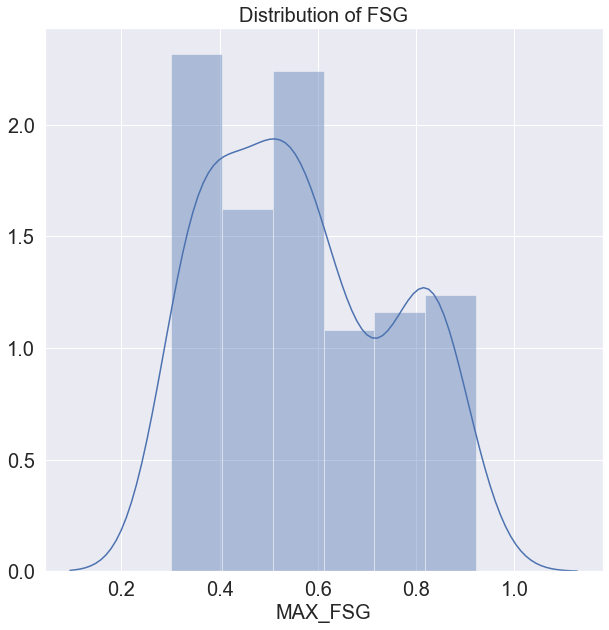

0.311    3
0.800    2
0.553    2
0.351    2
0.510    2
        ..
0.503    1
0.691    1
0.814    1
0.391    1
0.697    1
Name: MAX_FSG, Length: 109, dtype: int64

In [98]:
fsg_distribution(df_exp_noncort, 'MAX_FSG')
df_exp_noncort['MAX_FSG'].value_counts()

In [99]:
def binned_dist(dataframe):
    
    sns.set(rc={'figure.figsize':(50,50)})
    #dataframe = dataframe.dropna() 

    dist = sns.FacetGrid(dataframe, hue="fsg_descript")
    dist = dist.map(sns.distplot, "MAX_FSG", hist=True)
    #plt.legend("cloze_probability", fontsize=10)
    plt.xlabel("FSG", fontsize=20)
    #plt.title(f'Distribution of cloze probability', fontsize=20);
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10);

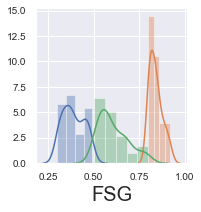

In [100]:
binned_dist(df_exp_noncort)

In [101]:
df_exp_noncort

,MAX_TARGET,MIN_#G,MAX_#G,MAX_#P,MIN_CUE,MAX_CUE,MAX_FSG,MIN_FSG,MIN_#P,MIN_TARGET,random_word,fsg_descript
273,perfume,140.0,140.0,64.0,cologne,cologne,0.457,0.014,2.0,face,woods,low fsg
244,pants,156.0,156.0,132.0,trousers,trousers,0.846,0.019,3.0,shirt,yard,high fsg
65,wood,154.0,154.0,47.0,carpenter,carpenter,0.305,0.013,2.0,rug,yuck,low fsg
493,ice,147.0,147.0,50.0,cube,cube,0.340,0.014,2.0,triangle,section,low fsg
83,driver,179.0,179.0,54.0,screw,screw,0.302,0.011,2.0,turn,lymph,low fsg
26,night,138.0,138.0,113.0,day,day,0.819,0.014,2.0,break,rock,high fsg
148,adults,151.0,151.0,87.0,grown-ups,grown-ups,0.576,0.013,2.0,big,take,medium fsg
336,ice cream,146.0,146.0,82.0,cone,cone,0.562,0.014,2.0,triangle,reasoning,medium fsg
435,art,153.0,153.0,86.0,crafts,crafts,0.562,0.013,2.0,popsicle sticks,save,medium fsg
141,mad,148.0,148.0,77.0,angry,angry,0.520,0.014,2.0,violent,spend,medium fsg


## CoRT Stimuli

In [102]:
#load current database (for ones w/ RT data)
cort = CoRTLanguageExp()
df_og_extremes = cort.load_dataframe()

In [103]:
df_og_extremes.columns
#df_og_extremes['participant_id']

Index(['local_date', 'experiment_id', 'experiment_version',
       'participant_public_id', 'participant_id', 'task_name', 'task_version',
       'spreadsheet_version', 'spreadsheet_row', 'sentence_num', 'zone_type',
       'rt', 'response', 'attempt', 'correct', 'incorrect', 'display',
       'block_num', 'randomise_blocks', 'full_sentence', 'last_word',
       'sampled', 'CoRT_descript', 'CoRT_mean', 'condition_name', 'CoRT_std',
       'cloze_descript', 'cloze_probability', 'dataset', 'random_word',
       'target_word', 'word_count', 'group', 'cause_effect', 'dynamic_verb',
       'orientation', 'negative', 'tense', 'spelling_modified', 'trial_type',
       'version', 'version_descript', 'group_cloze_condition',
       'group_CoRT_condition', 'group_trial_type', 'cloze_cort'],
      dtype='object')

In [104]:
#rename cloze column/values for later concat
df_og_extremes['condition_name'] = df_og_extremes['condition_name'].replace({'hard': 'low cloze', 'easy':'high cloze'})
df_og_extremes = df_og_extremes.rename({'condition_name':'cloze_descript'})
df_og_extremes['cloze_descript']

311      high cloze
324      high cloze
337       low cloze
350       low cloze
363       low cloze
            ...    
42041     low cloze
42051    high cloze
42063    high cloze
42076    high cloze
42087    high cloze
Name: cloze_descript, Length: 9920, dtype: object

In [105]:
mean = df_og_extremes["rt"].mean()

df_low = df_og_extremes.query('cloze_descript=="low cloze"')
low_mean = df_low["rt"].mean()

df_high = df_og_extremes.query('cloze_descript=="high cloze"')
high_mean = df_high["rt"].mean()

print(low_mean)
print(high_mean)

907.3115525171098
833.800530677306


In [106]:
def _make_grouped_sentences_dataframe(df, task_name = "cort_language", versions = [10], **kwargs):
    """ 
    *create dataframe with the sentences grouped (i.e. one row for each sentence) and columns for mean and std of correct column.

        Kwargs: 
            rt_min (int): desired minimum rt of correct responses

        Returns:
            shortened dataframe only with rows (i.e. sentences) with a correct score below minimum desired.

        example input: _make_grouped_sentences_dataframe(correct_min = 0.5)
    """
    # run clean data first
    #dataframe = self.clean_data(task_name=task_name, versions=versions, **kwargs)

    # group sentences and find mean and standard deviation for each
    df_by_sentence = df.groupby(['full_sentence', 'last_word','target_word','random_word', 'trial_type', 'cloze_descript', 'cloze_probability', 'CoRT_descript']).agg({'rt': ['mean', 'std']}).reset_index()

    # join multilevel columns
    df_by_sentence.columns = ["_".join(pair) for pair in df_by_sentence.columns]
    df_by_sentence.columns = df_by_sentence.columns.str.strip('_')
    
    # only select meaningful -- do here or below
    #df_by_sentence = df_by_sentence.query('trial_type == "meaningful"')

    def _select_correct_min_mean(correct_min):
        # only returns sentences below a minimum percent of correct responses
        # input: a decimal between 0-1 

        return df_by_sentence.loc[df_by_sentence['rt_mean'] <= correct_min]

    if kwargs.get('rt_min'):
        correct_min = kwargs['rt_min']
        df_by_sentence = _select_correct_min_mean(correct_min)

    return df_by_sentence

In [107]:
df_grouped = _make_grouped_sentences_dataframe(df_og_extremes)
df_grouped

,full_sentence,last_word,target_word,random_word,trial_type,cloze_descript,cloze_probability,CoRT_descript,rt_mean,rt_std
0,Abby|stuck|his|picture|to|her|wall|with|a,tack,tack,lab,meaningful,low cloze,0.46,CoRT,923.985484,281.001590
1,"According|to|the|Bible,|murder|is|a",sin,sin,hoop,meaningful,high cloze,0.96,non-CoRT,816.844521,262.430829
2,"After|Grace|slipped|on|the|floor,|she|bought|a",wind,rug,wind,meaningless,low cloze,0.45,CoRT,920.749181,205.685581
3,"After|driving|over|sharp|glass,|Ronald|had|a|flat",tire,tire,loan,meaningful,high cloze,1.00,CoRT,735.651615,210.392888
4,"After|his|divorce,|my|neighbor|was|a|lonely",man,man,miss,meaningful,low cloze,0.46,non-CoRT,823.780093,314.993064
5,"After|hitting|the|iceberg,|the|ship|began|to",sink,sink,milk,meaningful,high cloze,0.96,CoRT,782.244079,333.048179
6,After|missing|lunch|Harry|badly|needed|some,food,food,fall,meaningful,high cloze,0.84,non-CoRT,752.862895,246.387311
7,"After|raking|the|yard,|Pat|jumped|into|the|pil...",leaves,leaves,tag,meaningful,high cloze,0.92,CoRT,732.269671,250.126406
8,"After|receiving|a|treat,|the|dog's|tail|began|to",work,wag,work,meaningless,high cloze,0.98,CoRT,1002.306286,374.503642
9,"After|receiving|bad|news,|the|patient|began|to",steroids,cry,steroids,meaningless,high cloze,0.83,CoRT,903.205333,178.197078


In [108]:
#df_grouped.sort_values(by="rt", key=pd.Series.abs)
#df_grouped.reindex(df_grouped.rt_mean.mean().sort_values().index)
#df_grouped = df_grouped.iloc[df_grouped['rt_mean'].abs().argsort()].reset_index(drop=True)
#df_grouped["rt_mean"] = df_grouped["rt_mean"].astype(int)

In [109]:
df_drop_outliers = df_grouped[(df_grouped["rt_mean"] > 50-high_mean) & (df_grouped["rt_mean"] < 100+low_mean)]
df_drop_outliers
#more variability in low cloze condition

,full_sentence,last_word,target_word,random_word,trial_type,cloze_descript,cloze_probability,CoRT_descript,rt_mean,rt_std
0,Abby|stuck|his|picture|to|her|wall|with|a,tack,tack,lab,meaningful,low cloze,0.46,CoRT,923.985484,281.001590
1,"According|to|the|Bible,|murder|is|a",sin,sin,hoop,meaningful,high cloze,0.96,non-CoRT,816.844521,262.430829
2,"After|Grace|slipped|on|the|floor,|she|bought|a",wind,rug,wind,meaningless,low cloze,0.45,CoRT,920.749181,205.685581
3,"After|driving|over|sharp|glass,|Ronald|had|a|flat",tire,tire,loan,meaningful,high cloze,1.00,CoRT,735.651615,210.392888
4,"After|his|divorce,|my|neighbor|was|a|lonely",man,man,miss,meaningful,low cloze,0.46,non-CoRT,823.780093,314.993064
5,"After|hitting|the|iceberg,|the|ship|began|to",sink,sink,milk,meaningful,high cloze,0.96,CoRT,782.244079,333.048179
6,After|missing|lunch|Harry|badly|needed|some,food,food,fall,meaningful,high cloze,0.84,non-CoRT,752.862895,246.387311
7,"After|raking|the|yard,|Pat|jumped|into|the|pil...",leaves,leaves,tag,meaningful,high cloze,0.92,CoRT,732.269671,250.126406
8,"After|receiving|a|treat,|the|dog's|tail|began|to",work,wag,work,meaningless,high cloze,0.98,CoRT,1002.306286,374.503642
9,"After|receiving|bad|news,|the|patient|began|to",steroids,cry,steroids,meaningless,high cloze,0.83,CoRT,903.205333,178.197078


In [110]:
df_extremes_filt = df_drop_outliers.query('trial_type == "meaningful"') # can do earlier too
df_extremes_filt = df_extremes_filt.sort_values("CoRT_descript").head(100)
df_extremes_filt

,full_sentence,last_word,target_word,random_word,trial_type,cloze_descript,cloze_probability,CoRT_descript,rt_mean,rt_std
0,Abby|stuck|his|picture|to|her|wall|with|a,tack,tack,lab,meaningful,low cloze,0.46,CoRT,923.985484,281.001590
212,The|box|landed|on|the|ground|with|a|dull,thud,thud,net,meaningful,high cloze,0.85,CoRT,938.316189,351.955259
207,The|boat|passed|easily|under|the,bridge,bridge,lodge,meaningful,high cloze,0.89,CoRT,746.385973,232.160357
204,The|baby's|ice|cream|was|snatched|up|by|the,dog,dog,time,meaningful,low cloze,0.47,CoRT,901.622437,310.747837
203,The|accountant|ironed|a|shirt|before|going|to,work,work,lies,meaningful,high cloze,0.90,CoRT,744.810643,301.628339
200,They|were|startled|by|the|sudden,noise,noise,night,meaningful,low cloze,0.50,CoRT,867.555641,203.161627
199,They|broke|into|the|store|and|began|to,steal,steal,joke,meaningful,low cloze,0.42,CoRT,900.183385,339.071350
187,Stacy|was|not|careful|and|spilled|wine|on|her,dress,dress,noises,meaningful,low cloze,0.44,CoRT,852.486812,310.553215
184,"Soon|after|Janice|stepped|on|the|wet|floor,|she",slipped,slipped,crowd,meaningful,high cloze,0.82,CoRT,856.253560,310.821749
181,She|washed|the|dirty|dishes|in|the,sink,sink,batch,meaningful,high cloze,0.92,CoRT,690.645969,193.152974


In [111]:
def cloze_distribution(dataframe):
    """ plots distribution of cloze probabilities
        Args:
            dataframe
    """
    plt.figure(figsize=(10,10))

    sns.distplot(dataframe['cloze_probability'])
    plt.xlabel('cloze probability', fontsize=20)
    plt.title('Distribution of cloze probability', fontsize=20);
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20);
    plt.show()

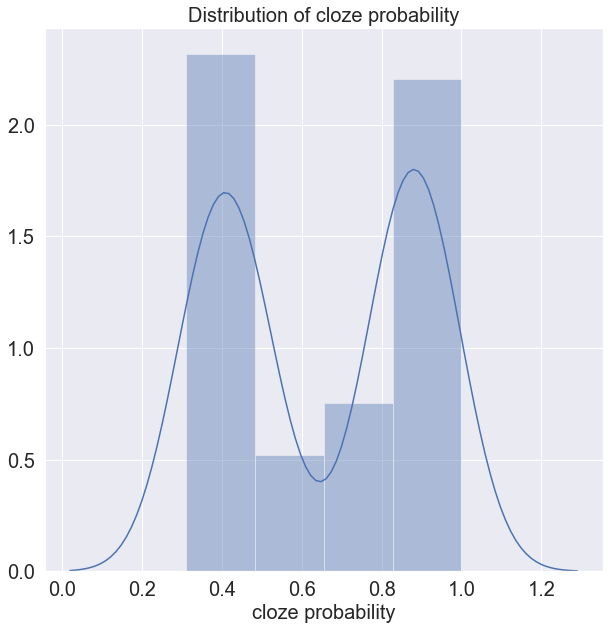

high cloze    51
low cloze     49
Name: cloze_descript, dtype: int64

In [112]:
cloze_distribution(df_extremes_filt)
df_extremes_filt["cloze_descript"].value_counts()
#not much difference if use average mean

In [113]:
#cort_distribution(df_exp_cort)
df_extremes_filt["CoRT_descript"].value_counts()

CoRT    100
Name: CoRT_descript, dtype: int64

In [114]:
#also pick sents in 0.5-0.8 range cloze (want even bell-shaped)
#50/50/50 low/med/high

In [115]:
# load in df for middle cloze values (0.5-0.8 range) (note: no RT data)
df_og_middle = pd.read_csv(os.path.join(Defaults.STIM_DIR, 'sentence_validation.csv'))

In [116]:
df_middle_filt = df_og_middle.query('cloze_descript=="medium cloze" and CoRT_descript=="strong CoRT"')
df_middle_filt
#930 w/out cort filter

,full_sentence,cloze_probability,dataset,CoRT_mean,CoRT_std,CoRT_descript,target_word,random_word,word_count,cloze_descript
23,Aaron|wrote|the|lesson|on|the|board|with|colorful,0.61,peele,4.400000,0.547723,strong CoRT,chalk,burp,9,medium cloze
24,Abbey|pushed|to|open|the|door|when|she|needed|to,0.68,block_baldwin,4.500000,0.836660,strong CoRT,pull,ham,10,medium cloze
31,"After|Ashley|left|the|bananas|out,|they|turned|to",0.71,peele,4.000000,0.000000,strong CoRT,mush,milk,9,medium cloze
32,"After|Chris|dropped|bread|in|the|water,|it|became",0.78,peele,4.600000,0.547723,strong CoRT,soggy,stand,9,medium cloze
45,After|accidentally|swallowing|a|bug|he|began|to,0.66,block_baldwin,4.000000,1.264911,strong CoRT,cough,feet,8,medium cloze
49,"After|chugging|the|soda,|Peter|let|out|a|loud",0.59,peele,4.250000,0.957427,strong CoRT,burp,washer,9,medium cloze
57,After|dinner|the|maid|collected|the|family’s,0.78,block_baldwin,4.000000,1.414214,strong CoRT,plates,deer,7,medium cloze
58,After|dinner|they|washed|the,0.60,block_baldwin,4.000000,1.549193,strong CoRT,dishes,snob,5,medium cloze
63,"After|eating|the|peach,|the|child|threw|out|the",0.79,peele,4.000000,1.224745,strong CoRT,pit,milk,9,medium cloze
68,"After|getting|hit|by|the|ball,|Tyler|started|to",0.71,peele,4.666667,0.516398,strong CoRT,cry,monster,9,medium cloze


In [117]:
df_middle_filt = df_middle_filt.head(50)

In [118]:
#concat extremes and middle cloze dfs
df_exp_cort = pd.concat([df_extremes_filt, df_middle_filt]).sample(frac = 1)
df_exp_cort
#all rows w/ CoRT_descript, cloze_descript, cloze_probability

,CoRT_descript,CoRT_mean,CoRT_std,cloze_descript,cloze_probability,dataset,full_sentence,last_word,random_word,rt_mean,rt_std,target_word,trial_type,word_count
49,CoRT,NaN,NaN,low cloze,0.41,NaN,"Before|descending|the|canyon,|we|hiked|the",trail,dress,872.315034,320.988387,trail,meaningful,NaN
286,CoRT,NaN,NaN,high cloze,0.82,NaN,The|toddler|jumped|but|the|jar|was|out|of,reach,pet,897.380000,279.678126,reach,meaningful,NaN
313,CoRT,NaN,NaN,low cloze,0.49,NaN,"When|the|building|came|down,|there|was|a|loud",crash,port,858.270579,283.322790,crash,meaningful,NaN
216,CoRT,NaN,NaN,high cloze,0.88,NaN,The|bride|smiled|as|she|walked|down|the,aisle,bread,685.960796,201.462883,aisle,meaningful,NaN
407,strong CoRT,4.500000,0.836660,medium cloze,0.71,block_baldwin,Denise|struck|her|attacker|a|heavy,NaN,rock,NaN,NaN,blow,NaN,6.0
318,strong CoRT,4.166667,1.602082,medium cloze,0.69,block_baldwin,Billy|hit|his|sister|on|the,NaN,salt,NaN,NaN,head,NaN,6.0
133,CoRT,NaN,NaN,high cloze,0.85,NaN,Jan|tried|to|squeeze|in|but|there|was|no,room,fly,766.667413,303.307753,room,meaningful,NaN
45,CoRT,NaN,NaN,high cloze,0.80,NaN,A|nearby|woman|sprayed|the|robber|with,mace,budge,819.926945,206.716302,mace,meaningful,NaN
45,strong CoRT,4.000000,1.264911,medium cloze,0.66,block_baldwin,After|accidentally|swallowing|a|bug|he|began|to,NaN,feet,NaN,NaN,cough,NaN,8.0
474,strong CoRT,4.333333,1.211060,medium cloze,0.54,peele,"During|the|violent|storm,|lightning|struck|the...",NaN,dull,NaN,NaN,roof,NaN,8.0


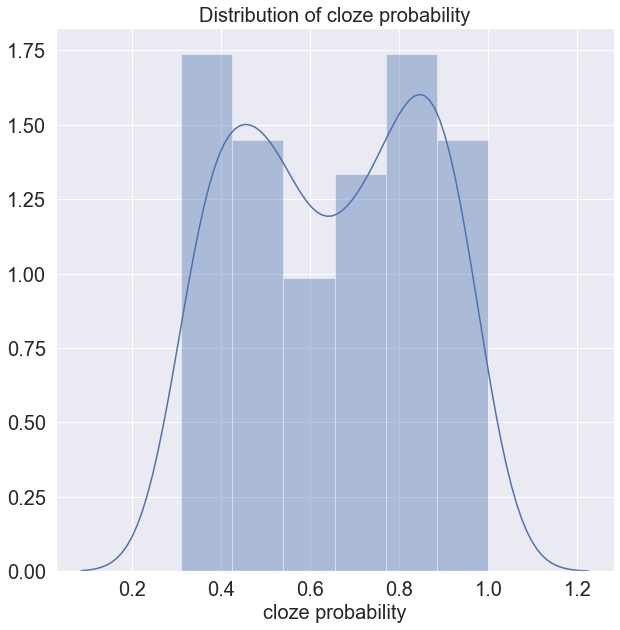

high cloze      51
medium cloze    50
low cloze       49
Name: cloze_descript, dtype: int64

In [119]:
cloze_distribution(df_exp_cort)
df_exp_cort["cloze_descript"].value_counts()

In [120]:
df_exp_cort["CoRT_descript"].value_counts()

CoRT           100
strong CoRT     50
Name: CoRT_descript, dtype: int64

In [121]:
def binned_distribution(dataframe):
    
    sns.set(rc={'figure.figsize':(50,50)})
    #dataframe = dataframe.dropna() 

    dist = sns.FacetGrid(dataframe, hue="cloze_descript")
    dist = dist.map(sns.distplot, "cloze_probability", hist=True)
    #plt.legend("cloze_probability", fontsize=10)
    plt.xlabel("Cloze Probability", fontsize=20)
    #plt.title(f'Distribution of cloze probability', fontsize=20);
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10);

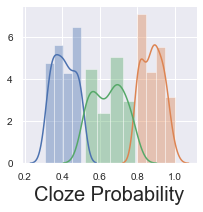

In [122]:
binned_distribution(df_exp_cort)

## CoRT/non-CoRT merge

In [123]:
df_exp_noncort.head(5)

,MAX_TARGET,MIN_#G,MAX_#G,MAX_#P,MIN_CUE,MAX_CUE,MAX_FSG,MIN_FSG,MIN_#P,MIN_TARGET,random_word,fsg_descript
273,perfume,140.0,140.0,64.0,cologne,cologne,0.457,0.014,2.0,face,woods,low fsg
244,pants,156.0,156.0,132.0,trousers,trousers,0.846,0.019,3.0,shirt,yard,high fsg
65,wood,154.0,154.0,47.0,carpenter,carpenter,0.305,0.013,2.0,rug,yuck,low fsg
493,ice,147.0,147.0,50.0,cube,cube,0.340,0.014,2.0,triangle,section,low fsg
83,driver,179.0,179.0,54.0,screw,screw,0.302,0.011,2.0,turn,lymph,low fsg


In [124]:
df_exp_noncort["trial_type"] = "non-cort"

In [125]:
#df_exp_noncort["random_word"]

In [126]:
df_exp_cort.head(5)

,CoRT_descript,CoRT_mean,CoRT_std,cloze_descript,cloze_probability,dataset,full_sentence,last_word,random_word,rt_mean,rt_std,target_word,trial_type,word_count
49,CoRT,NaN,NaN,low cloze,0.41,NaN,"Before|descending|the|canyon,|we|hiked|the",trail,dress,872.315034,320.988387,trail,meaningful,NaN
286,CoRT,NaN,NaN,high cloze,0.82,NaN,The|toddler|jumped|but|the|jar|was|out|of,reach,pet,897.380000,279.678126,reach,meaningful,NaN
313,CoRT,NaN,NaN,low cloze,0.49,NaN,"When|the|building|came|down,|there|was|a|loud",crash,port,858.270579,283.322790,crash,meaningful,NaN
216,CoRT,NaN,NaN,high cloze,0.88,NaN,The|bride|smiled|as|she|walked|down|the,aisle,bread,685.960796,201.462883,aisle,meaningful,NaN
407,strong CoRT,4.5,0.83666,medium cloze,0.71,block_baldwin,Denise|struck|her|attacker|a|heavy,NaN,rock,NaN,NaN,blow,NaN,6.0


In [127]:
df_exp_cort["trial_type"] = "cort"

In [128]:
df_exp = df_exp_noncort.append(df_exp_cort)

In [129]:
out_path = os.path.join(Defaults.TARGET_DIR, f"followup_test.csv")
df_exp.to_csv(out_path, header=True)

## CoRT and non-CoRT word overlap

In [ ]:
# how do for all rows in all columns (not manually)?
df_exp_noncort['MAX_CUE'] = df_exp_noncort['MAX_CUE'].str.lower()
df_exp_noncort['MAX_CUE'] = df_exp_noncort['MAX_CUE'].str.replace(' ', '')

#df_exp_noncort['MIN_TARGET'] = df_exp_noncort['MIN_TARGET'].str.lower()
#df_exp_noncort['MIN_TARGET'] = df_exp_noncort['MIN_TARGET'].str.replace(' ', '')

In [ ]:
target_word_cort = df_exp_cort['target_word'].values 
# not have 'last_word' for middle cloze sents (only target and random) but selected 4 only meaningful
# even more overlap if use df_og_extremes, df_og_middle -> prioritize overlap in filt cort? prob not
target_word_noncort = df_exp_noncort['MAX_CUE'].values #accounting for all possible
# want cue word or target word overlap?

In [ ]:
#c = target_word_cort.Intersect(target_word_noncort).ToArray()
len(list(set(target_word_cort) & set(target_word_noncort)))
overlap_words = np.array(list(set(target_word_cort) & set(target_word_noncort)))
overlap_words

# prioritize these rows in filtering df_exp_noncort?
# 61 if not select 4 just meaningful

In [ ]:
df_overlap = df_exp_noncort.loc[df_exp_noncort['MAX_TARGET'].isin(overlap_words)]
df_overlap = df_overlap.drop_duplicates(subset=['MAX_TARGET'])
len(df_overlap)

In [ ]:
fsg_distribution(df_overlap, 'MAX_FSG')

In [ ]:
# how select 100 others? in range 0.5-1.0
df_exp_noncort_rest = df_exp_noncort[df_exp_noncort['MAX_FSG'].between(0.5, 1.0, inclusive=True)]
df_exp_noncort_rest = df_exp_noncort_rest.sample(frac = 1)
df_exp_noncort_rest

In [ ]:
df_exp_noncort_rest = df_exp_noncort_rest.head(100)
#.sort_values('MAX_FSG', ascending = False)
#df_exp_noncort_rest

df_exp_noncort_merged = df_exp_noncort_rest.append(df_overlap, ignore_index = True)
df_exp_noncort_merged = df_exp_noncort_merged.sample(frac = 1)
df_exp_noncort_merged

In [ ]:
fsg_distribution(df_exp_noncort_merged, 'MAX_FSG')

In [ ]:
# could also sample from dif ranges (FROM LOW, MEDIUM, HIGH)